# Statistical Analysis
In this section, I will take our clean and explored data and build a logistic regression model.

The model will use our "Great Game" classification as the variable we are trying to pick. It will then use any other variables to predict whether a game is going to be great.

Lets load our cleaned and explored data set:

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import statsmodels.api as sm
from sklearn.metrics import classification_report
import scipy.stats as stats

In [2]:
#####

# File 1 - Board Games

# Load the CSV file
df1 = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df1['Adjusted Release Year'] = df1['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Calculate the number of years since the games adjusted release year
df1['Years Since Release'] = 2024 - df1['Adjusted Release Year']
df1['Years Since Release'] = df1['Years Since Release'].replace(0,1)

# Calculate votes per year rounded to nearest whole number
df1['Votes per Adjusted Release Year'] = df1['Voters'] / df1['Years Since Release']
df1['Votes per Adjusted Release Year'] = df1['Votes per Adjusted Release Year'].round(0).astype(int)

# Calculate the standard deviation on Votes per Adjusted Release Year and apply it as a weighting column
mean_votes = df1['Votes per Adjusted Release Year'].mean()
std_dev_votes = df1['Votes per Adjusted Release Year'].std(ddof=0)
df1['SDs from Mean'] = (df1['Votes per Adjusted Release Year'] - mean_votes) / std_dev_votes
df1['SD Weight'] = 1 / ((df1['SDs from Mean'].abs() + 1))
df1['Weighted Result'] = df1['Votes per Adjusted Release Year'] * df1['SD Weight']
df1['Weighted Result'] = df1['Weighted Result'].round(2)

# Normalised results on a scale of -1 to 1 and name it Popularity
min_sd = df1['Weighted Result'].min()
max_sd = df1['Weighted Result'].max()
df1['Popularity'] = 2 * ((df1['Weighted Result'] - min_sd) / (max_sd - min_sd)) - 1
df1['Popularity'] = df1['Popularity'].round(2)

# Normalised Geek Rating on a scale of -1 to 1 and name it Quality
min_sd = df1['Geek Rating'].min()
max_sd = df1['Geek Rating'].max()
df1['Quality'] = 2 * ((df1['Geek Rating'] - min_sd) / (max_sd - min_sd)) - 1
df1['Quality'] = df1['Quality'].round(2)

# Add a column called score
df1['Score'] = df1['Popularity'] + df1['Quality']

# Add a column called 'Great Game' which shows True or False based on Quality and Popularity >= 0.4
df1['Great Game'] = (df1['Quality'] >= 0.4) & (df1['Popularity'] >= 0.4)

#####

# File 2 - Board Game Info

# Load the CSV file
df2 = pd.read_csv('Boardgame_Info_Cleaned_File.csv') 

# Fields to winsorize
columns_to_winsorize = ['Price', 'Max players', 'Min time (mins)', 'Max time (mins)']

# Calculate 99th percentile and Clip and cap the values
for col in columns_to_winsorize:
    upper_cap = df2[col].quantile(0.99)
    df2[col] = df2[col].clip(upper=upper_cap)
    df2[col] = df2[col].apply(lambda x: upper_cap if x > upper_cap else x)

# Add a new column for average playtime
df2['Average playtime (mins)'] = (df2['Min time (mins)'] + df2['Max time (mins)']) / 2

# Get the unique types from both columns
unique_types = pd.unique(df2[['Type 1', 'Type 2']].values.ravel('K'))

# Create columns for each unique type and set the category
for type in unique_types:
    df2[type] = ((df2['Type 1'] == type) | (df2['Type 2'] == type)).astype(int)

#####

# File 3 - Local Store Info

# Load the CSV file
df3 = pd.read_csv('My_Local_BG_Store_Cleaned_File.csv') 

#####

# Merge Board Games with Board Game Info on Title
df1['Title'] = df1['Title'].str.strip()
df2['Title'] = df2['Title'].str.strip()
merged_df1 = pd.merge(df1, df2, on='Title', how='inner')

# Create a new column 'Local Store' in merged_df1 with 1 if the title is in df3 and 0 if not
merged_df1['Local Store'] = merged_df1['Title'].apply(lambda x: 1 if x in df3['Title'].values else 0)

#####

# File 4 - Review Counts

# Load the CSV file
df4 = pd.read_csv('Boardgames_Reviews_SQL_Cleaned_File.csv') 

# Create the new column 'First Year Review Count'
df4['First Year Review Count'] = df4.apply(lambda row: row[str(row['Adjusted Release Year'] + 1)], axis=1)

#####

# Add early review count column to merged file
merged_df1 = merged_df1.merge(df4[['Game ID', 'First Year Review Count']], on='Game ID', how='left')

#####

# Use panda NULL
merged_df1.replace('',pd.NA, inplace=True)

# Handling NULL values by replacing them with the mean
for column in merged_df1.select_dtypes(include=['number']).columns:
    merged_df1[column].fillna(merged_df1[column].mean(), inplace=True)

######

# Show the top 10 rows
# merged_df1.head(10)

# Export the cleaned and merged DataFrame to an Excel file
merged_df1.to_excel('Cleaned_Boardgames_Data.xlsx', index=False)

print("File exported successfully as 'Cleaned_Boardgames_Data.xlsx'")


File exported successfully as 'Cleaned_Boardgames_Data.xlsx'


## Check the data:

In [3]:
merged_df1.shape
merged_df1.info()
merged_df1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24969 entries, 0 to 24968
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Rank                             24969 non-null  int64  
 1   Game ID                          24969 non-null  int64  
 2   Title                            24969 non-null  object 
 3   Description                      13481 non-null  object 
 4   Release Year                     24969 non-null  int64  
 5   Geek Rating                      24969 non-null  float64
 6   Avg Rating                       24969 non-null  float64
 7   Voters                           24969 non-null  int64  
 8   Adjusted Release Year            24969 non-null  int64  
 9   Years Since Release              24969 non-null  int64  
 10  Votes per Adjusted Release Year  24969 non-null  int64  
 11  SDs from Mean                    24969 non-null  float64
 12  SD Weight         

,Rank,Game ID,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year,SDs from Mean,...,Thematic,Family,Customizable,Abstract,Party,Wargames,Children's,NaN,Local Store,First Year Review Count
count,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,...,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.0,24969.000000,24969.000000
mean,13569.037406,141285.073932,2006.927670,5.688095,6.429900,1069.958348,2011.461012,12.538988,148.515119,0.010389,...,0.064600,0.124314,0.013577,0.055669,0.033642,0.163923,0.039008,0.0,0.017061,102.713525
std,8212.740143,121545.946315,35.798081,0.363171,0.888691,4554.157983,7.527665,7.527665,612.654261,1.023603,...,0.245824,0.329946,0.115728,0.229286,0.180309,0.370213,0.193619,0.0,0.129502,399.944894
min,1.000000,1.000000,400.000000,4.554000,1.270000,30.000000,2001.000000,1.000000,1.000000,-0.236075,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,6316.000000,15542.000000,2003.000000,5.509000,5.870000,63.000000,2003.000000,6.000000,5.000000,-0.229392,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000
50%,13201.000000,137841.000000,2013.000000,5.543000,6.470000,146.000000,2013.000000,11.000000,16.000000,-0.211013,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,18.000000
75%,20901.000000,244654.000000,2018.000000,5.679000,7.030000,482.000000,2018.000000,21.000000,64.000000,-0.130816,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,102.713525
max,27891.000000,404268.000000,2023.000000,8.407000,9.460000,132623.000000,2023.000000,23.000000,20046.000000,33.254458,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,16683.000000


## Feature Selection
When selecting features, I needed to be careful not to select any that "give away the ending". For example, I made sure to remove:
- Popularity
- Quality
- Score
- Geek Rating
- Voters
- Avg Rating

These features are directly, (or closely) used in how we calculate what a "Great Game" is, and we will not necessarily know this information in a games early stages to be able to predict if a game is going to be successful. 

The remaining fields:
- First Year Review Count
- Average playtime (mins)
- Complexity
- Price
- Max players
- Age Rating
- Local Store
- Adjusted Release Year
- Min players
- Strategy
- Thematic
- Family
- Customizable
- Abstract
- Party
- Wargames
- Children's

Can all be used to help us predict, based on a games first year of release, is it going to take off into the realms of the greats.

In the below code, we define these features and create our training and test split at a ratio of 70/30.

In [4]:
# Define features
features = ['First Year Review Count', 'Average playtime (mins)', 'Complexity', 'Price', 'Max players', 'Age Rating', 'Local Store', 'Adjusted Release Year', 'Min players', 'Strategy', 'Thematic', 'Family', 'Customizable', 'Abstract', 'Party', 'Wargames', 'Children\'s']

X = merged_df1[features]
y = merged_df1['Great Game']

#Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17478, 17)
X_test shape: (7491, 17)
y_train shape: (17478,)
y_test shape: (7491,)


Here we can check that once the data is split into training and test, that great games fall into both categories at a roughly equal and random rate.

In [5]:
#Check proportion of contact received split
print("Training set target distribution:\n", y_train.value_counts(normalize=True))
print("Test set target distribution:\n", y_test.value_counts(normalize=True))

Training set target distribution:
 Great Game
False    0.985067
True     0.014933
Name: proportion, dtype: float64
Test set target distribution:
 Great Game
False    0.984915
True     0.015085
Name: proportion, dtype: float64


In [6]:
#What is the Y variable
print("\nTarget (y):")
print(y.head())


Target (y):
0    True
1    True
2    True
3    True
4    True
Name: Great Game, dtype: bool


In [7]:
#What are the x variables
print("Features (X):")
print(X.head())

Features (X):
   First Year Review Count  Average playtime (mins)  Complexity       Price  \
0              4601.000000                     90.0        3.89   84.990000   
1              7597.000000                     60.0        2.83   49.970000   
2               102.713525                    120.0        3.74   58.990000   
3              9610.000000                     90.0        3.90   50.738236   
4              2837.000000                    360.0        4.31  126.490000   

   Max players  Age Rating  Local Store  Adjusted Release Year  Min players  \
0          4.0        14.0            0                   2018          2.0   
1          4.0        13.0            0                   2015          2.0   
2          4.0        14.0            0                   2021          1.0   
3          4.0        14.0            0                   2017          1.0   
4          6.0        14.0            0                   2017          3.0   

   Strategy  Thematic  Family  Custo

Standardizing features means adjusting the values so they have a mean of 0 and a standard deviation of 1. This helps ensure that all features contribute equally to the model and improves its performance.

In [8]:
#Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#Build the model
model = LogisticRegression()

I decided to select all 17 features as we have such a large dataset, there is no risk to overfitting the model.

In [10]:
# Initialize RFE with the model and the number of features to select
rfe = RFE(model, n_features_to_select=17)

# Fit RFE to the training data
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=17)

If we ever want to decrease the number of features the model uses, this code automatically selects the most impactful features.

In [11]:
# Get the selected features
selected_features = rfe.support_

# Get the ranking of features
feature_ranking = rfe.ranking_

print("Selected Features:", selected_features)
print("Feature Ranking:", feature_ranking)

Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
#Only include selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

In [13]:
#Train the model
model.fit(X_train_rfe, y_train)

# Evaluate the model
y_pred = model.predict(X_test_rfe)

The below model evaluatiuon provide several metrics to check the performance of the model.

In [14]:
#Evaluate the model

# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Format the DataFrame
report_df['precision'] = (report_df['precision'] * 100).round(2).astype(str) + '%'
report_df['recall'] = (report_df['recall'] * 100).round(2).astype(str) + '%'
report_df['f1-score'] = (report_df['f1-score'] * 100).round(2).astype(str) + '%'
report_df['support'] = report_df['support'].astype(int)

# Display the formatted DataFrame
print(report_df)

             precision  recall f1-score  support
False            99.1%  99.91%    99.5%     7378
True            86.79%  40.71%   55.42%      113
accuracy        99.01%  99.01%   99.01%        0
macro avg       92.95%  70.31%   77.46%     7491
weighted avg    98.91%  99.01%   98.84%     7491


The above results tell us:
- Precision - **79.6%** of True predictions are True.
- Recall - **38.0%** of actual true instances found.
- Support - There are only 113 instances of the True class to be found, making finding them accurately more challenging.
- Accuracy - **98.9%** of predictions are correct.

This means the model is very accurate at predicting if a game will not reach "Great Game" status. 
The low recall for "Great Games" indicates that we might have an imbalance of feature representation. Meaning, maybe I have been a bit strict on what a great game is, or that many games just don't excel to such heights.

The below code helps visualise these results in a Confusion Matirx:

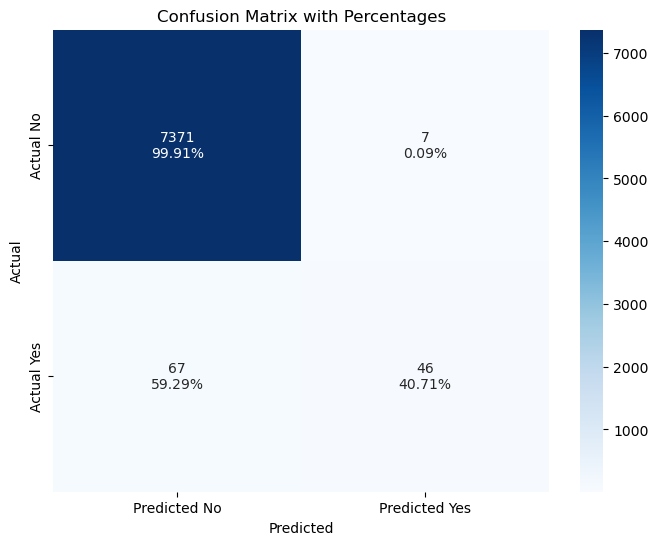

In [15]:
#Confusion Matrix

# Assuming y_test and y_pred are your true labels and predictions
cm = confusion_matrix(y_test, y_pred)

# Calculate the percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a combined matrix with counts and percentages
labels = np.array([f'{count}\n{percentage:.2%}' for count, percentage in zip(cm.flatten(), cm_percentage.flatten())]).reshape(2, 2)

# Plot the confusion matrix with the new labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Percentages')
plt.show()

We can see here that 99.6% of our "No" predictions were correct. 
38.0% of our "Yes" predictions were correct. This is likely due to the very low support volume of "Great Games" to find. 
To improve these results, I likely need to reduce the threshold for "Great Games".

However, our error analysis is favorable:
- Only 0.2% of our Yes predictions are actually No.
- 62.0% of our No predictions were actually Yes.

So many more nice surprises for Board Game creators as opposed to disappointments!

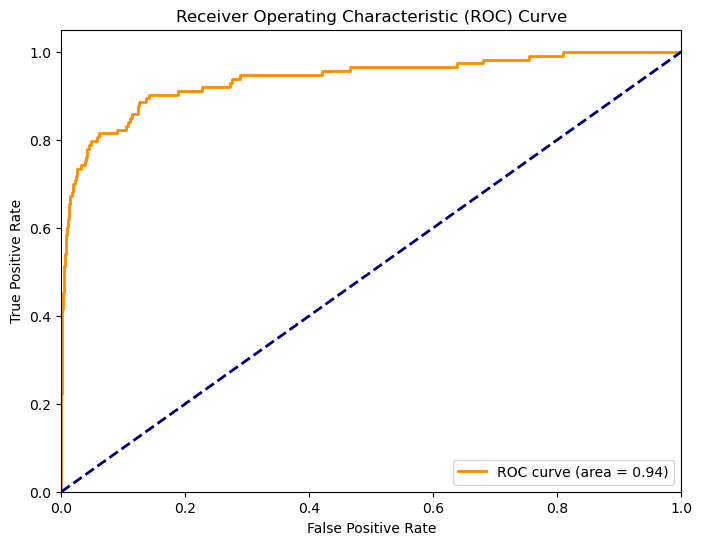

In [16]:
#ROC Curve

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_rfe)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Add a constant to the model (intercept)
X_train = sm.add_constant(X_train)

# Fit the logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

# Print the summary of 
print(result.summary())

         Current function value: 0.037656
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             Great Game   No. Observations:                17478
Model:                          Logit   Df Residuals:                    17460
Method:                           MLE   Df Model:                           17
Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                  0.5148
Time:                        07:04:39   Log-Likelihood:                -658.16
converged:                      False   LL-Null:                       -1356.3
Covariance Type:            nonrobust   LLR p-value:                9.407e-287
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -246.4267     37.973     -6.489      0.000    -320.853    -172.000
First Year Review Count   

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The ROC curve plots the True Positive Rate against the False Positive Rate. 

In short, if the orange line follows the blue diagonal line, it would indicate our model has no predictive power and is essentially randomly guessing. However I am pleased to see here that the model does hold predictive power.

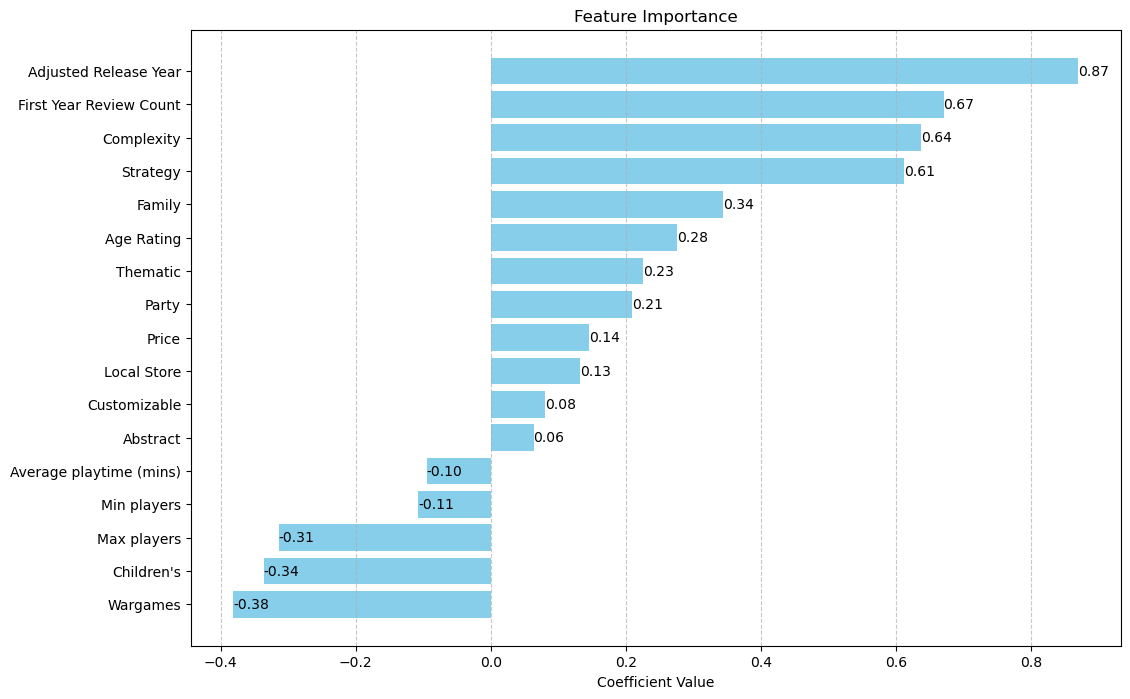

In [18]:
# Get the selected features
selected_features = rfe.support_

# Get the ranking of features
feature_ranking = rfe.ranking_

feature_names = ['First Year Review Count', 'Average playtime (mins)', 'Complexity', 'Price', 'Max players', 'Age Rating', 'Local Store', 'Adjusted Release Year', 'Min players', 'Strategy', 'Thematic', 'Family', 'Customizable', 'Abstract', 'Party', 'Wargames', 'Children\'s']

# Convert X_train_scaled to DataFrame
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
selected_feature_names = X_train_df.columns[selected_features]
X_train_selected = X_train_df.iloc[:, selected_features]

# Convert X_test_scaled to DataFrame
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
X_test_selected = X_test_df.iloc[:, selected_features]

# Assuming model is your trained logistic regression model
model = LogisticRegression()
model.fit(X_train_selected, y_train)

# Feature Importance
coefficients = model.coef_[0]
features = selected_feature_names

# Sort features by importance
sorted_indices = np.argsort(coefficients)
features = np.array(features)[sorted_indices]
coefficients = np.array(coefficients)[sorted_indices]

# Create a bar plot
plt.figure(figsize=(12, 8))
bars = plt.barh(np.arange(len(features)), coefficients, align='center', color='skyblue')
plt.yticks(np.arange(len(features)), features)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add annotations
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             ha='left', va='center', color='black')

plt.show()

The coefficients tells us the impact each variable has on the prediction. For example:
- The **Adjusted Release Year** has the strongest positive impact on whether a game will be great. This would suggest newer games are getting better.
- More complex games tend to do better.
- Strategy games are the strongest game type.
- Games with lots of players don't tend to be as popular.
- Wargames are the least likely game type to reach high popularity, likely due to there steep high point of enter in the hobby, and they are often older outdated games.
- Children's games perform poorly, whereas Family games perform better.

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


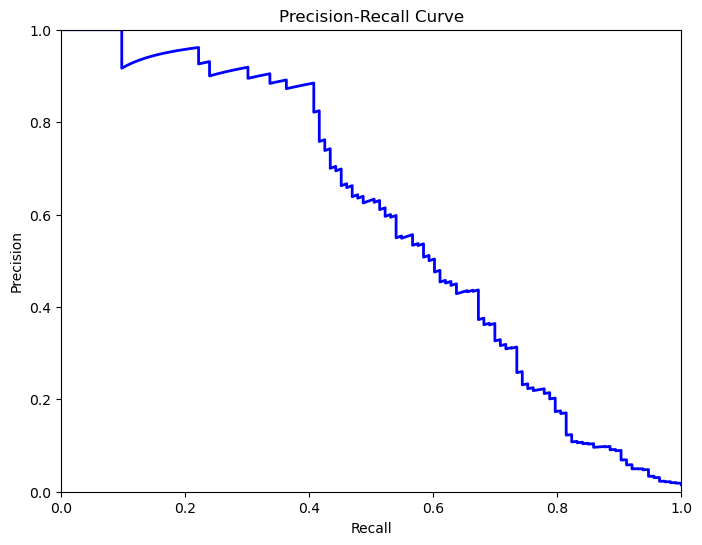

In [19]:
#Precision Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_rfe)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

The precision recall graph indicates how well the model can tell if a game is great at different threshold levels. 

For the model to be precise we want to see that is can accurately predict the correct result with a high precision. In our case, the area under the curve is rather large indicating that we probably need to increase our great game count so that the model has a better chance of predicting them. Needle in a haystack comes to mind.